# Extracting events from TCRM database

This notebook provides an interactive way of interrogating the event database generated by TCRM. 

In [1]:
%matplotlib inline
from __future__ import print_function, division

In [2]:
import os
import io
import sys

import database
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import statsmodels.api as sm

from scipy.stats import genpareto, scoreatpercentile, lognorm

from Utilities.config import ConfigParser
from Utilities.lmomentFit import samlmu, pelgev, pelgpa
from extremes import returnLevels, empReturnPeriod, returnPeriodUncertainty, gpdSelectThreshold
from distributions import fittedPDF

# Import widgets for interactive notebook
from ipywidgets import interact, fixed
import ipywidgets as widgets

import seaborn as sns
sns.set_context("poster")
sns.set_style("whitegrid")

/home/547/cxa547/venv/notebooks/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
configstr = """
[DataProcess]
InputFile=/g/data/w85/TCRM_data/tcrm-v2/input/Allstorms.ibtracs_wmo.v03r09.csv
Source=IBTRACS
StartSeason=1981
FilterSeasons=False

[Region]
; Domain for windfield and hazard calculation
gridLimit={'xMin':90.,'xMax':180.,'yMin':-30.0,'yMax':-5.0}
gridSpace={'x':1.0,'y':1.0}
gridInc={'x':1.0,'y':0.5}

[TrackGenerator]
NumSimulations=10000
YearsPerSimulation=1
SeasonSeed=68876543
TrackSeed=334825
TimeStep=1.0

[Input]
landmask = /g/data/w85/TCRM_data/tcrm-v2/input/landmask.nc
mslpfile = /g/data/w85/TCRM_data/tcrm-v2/MSLP/slp.day.ltm.nc
datasets = IBTRACS,LTMSLP

[Output]
Path=/g/data/w85/TCRM_data/tcrm-v2/

[Hazard]
Years=2,5,10,20,25,50,100,200,250,500,1000,2000,2500,5000
MinimumRecords=10
CalculateCI=False

[Logging]
LogFile=/g/data/w85/TCRM_data/tcrm-v2/log/tcrm-v2.log
LogLevel=INFO
Verbose=False

[IBTRACS]
; Input data file settings
url = ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r06/wmo/csv/Allstorms.ibtracs_wmo.v03r09.csv.gz
path = /g/data/w85/TCRM_data/tcrm-v2/input
filename = Allstorms.ibtracs_wmo.v03r09.csv
columns = tcserialno,season,num,skip,skip,skip,date,skip,lat,lon,skip,pressure
fielddelimiter = ,
numberofheadinglines = 3
pressureunits = hPa
lengthunits = km
dateformat = %Y-%m-%d %H:%M:%S
speedunits = kph

[LTMSLP]
; MSLP climatology file settings
URL = ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/surface/slp.day.1981-2010.ltm.nc
path = /g/data/w85/TCRM_data/tcrm-v2/MSLP
filename = slp.day.ltm.nc

[Process]
DatFile=/g/data/w85/TCRM_data/tcrm-v2/process/dat/tcrm-v2.dat
ExcludePastProcessed=False
"""

In [4]:
config = ConfigParser()
config.readfp(io.BytesIO(configstr))
numYears = config.getint('TrackGenerator', 'NumSimulations')

db = database.HazardDatabase(configstr)
locations = db.getLocations()
locNameList = list(locations['locName'])

In [5]:
def plotDiagnostics(data, mu, xi, sigma):
    """
    Create a 4-panel diagnostics plot of the fitted distribution.

    :param data: :class:`numpy.ndarray` of observed data values (in units
                 of metres/second).
    :param float mu: Selected threshold value.
    :param float xi: Fitted shape parameter.
    :param float sigma: Fitted scale parameter.

    """
    fig, ax = plt.subplots(2, 2)
    axes = ax.flatten()
    # Probability plots
    sortedmax = np.sort(data[data > mu])   
    gpdf = fittedPDF(data, mu, xi, sigma)
    pp_x = sm.ProbPlot(sortedmax)
    pp_x.ppplot(xlabel="Empirical", ylabel="Model", ax=axes[0], line='45')
    axes[0].set_title("Probability plot")

    prplot = sm.ProbPlot(sortedmax, genpareto, distargs=(xi,),
                         loc=mu, scale=sigma)
    prplot.qqplot(xlabel="Model", ylabel="Empirical", ax=axes[1], line='45')
    axes[1].set_title("Quantile plot")

    ax2 = axes[2]
    rp = np.array([1, 2, 5, 10, 20, 50, 100, 200,
                   500, 1000, 2000, 5000, 10000])
    rate = float(len(sortedmax)) / float(len(data))
    rval = returnLevels(rp, mu, xi, sigma, rate)

    emprp = empReturnPeriod(np.sort(data))
    ax2.semilogx(rp, rval, label="Fitted RP curve", color='r')
    ax2.scatter(emprp[emprp > 1], np.sort(data)[emprp > 1],
                color='b', label="Empirical RP", s=100)
    ax2.legend(loc=2)
    ax2.set_xlabel("Return period")
    ax2.set_ylabel("Return level")
    ax2.set_title("Return level plot")
    ax2.grid(True)
    maxbin = 4 * np.ceil(np.floor(data.max() / 4) + 1)
    sns.distplot(sortedmax, bins=np.arange(mu, maxbin, 2),
                 hist=True, axlabel='Wind speed (m/s)',
                 ax=axes[3])
    axes[3].plot(sortedmax, gpdf, color='r')
    axes[3].set_title("Density plot")
    plt.tight_layout()
    
def plotFit(data, mu, xi, sigma, title):
    """
    Plot a fitted distribution, with approximate 90% confidence interval
    and empirical return period values.

    :param data: :class:`numpy.ndarray` of observed data values.
    :param float mu: Selected threshold value.
    :param float xi: Fitted shape parameter.
    :param float sigma: Fitted scale parameter.
    :param str title: Title string for the plot.
    :param str figfile: Path to store the file (includes image format)

    """

    rp = np.array([1, 2, 5, 10, 20, 50, 100, 200,
                   500, 1000, 2000, 5000, 10000])
    rate = float(len(data[data > mu])) / float(len(data))
    rval = returnLevels(rp, mu, xi, sigma, rate)

    emprp = empReturnPeriod(data)
    err = returnPeriodUncertainty(data, mu, xi, sigma, rp)

    sortedmax = np.sort(data)
    fig, ax1 = plt.subplots(1, 1)
    ax1.semilogx(rp, rval, label="Fitted hazard curve")
    ax1.semilogx(rp, (rval + 1.96 * err), label="95% CI",
                 linestyle='--', color='0.5')
    ax1.semilogx(rp, (rval - 1.96 * err), linestyle='--', color='0.5')


    ax1.scatter(emprp[emprp > 1], sortedmax[emprp > 1], s=100,
                color='r', label="Empirical ARI")

    title_str = (title)  # + "\n" +
                 #r"$\mu$ = {0:.3f}, $\xi$ = {1:.5f}, $\sigma$ = {2:.4f}".
                 #format(mu, xi, sigma))
    ax1.set_title(title_str)
    ax1.set_ylim((0, 100))
    ax1.set_yticks(np.arange(0, 101, 10))
    ax1.set_xlim((1, 10000))
    ax1.set_ylabel('Wind speed (m/s)')
    ax1.set_xlabel('Average recurrence interval (years)')
    ax1.grid(which='major', linestyle='-')
    ax1.grid(which='minor', linestyle='--', linewidth=1)
    ax1.axhline(45.6, c='lime', linestyle='--', linewidth=2)#, label='Cat 3')
    ax1.axhline(62.5, c='darkorange', linestyle='--', linewidth=2)#, label='Cat 4')
    ax1.axhline(77.8, c='darkred', linestyle='--', linewidth=2)#, label='Cat 5')
    ax1.text(20000, 45.6, 'Cat 3', ha='center')
    ax1.text(20000, 62.5, 'Cat 4', ha='center')
    ax1.text(20000, 77.8, 'Cat 5', ha='center')
    ax1.legend(loc=2)

    fig2, ax2 = plt.subplots(1, 1)
    pr = 1./rp
    emppr = 1./emprp
    ax2.plot(rval, pr, label="Fitted AEP curve")
    ax2.scatter(sortedmax, emppr, s=100, color='r', label="Empirical AEP")
    ax2.axvline(45.6, c='lime', linestyle='--', linewidth=2)#, label='Cat 3')
    ax2.axvline(62.5, c='darkorange', linestyle='--', linewidth=2)#, label='Cat 4')
    ax2.axvline(77.8, c='darkred', linestyle='--', linewidth=2)#, label='Cat 5')
    ax2.text(45.6, 1.05, 'Cat 3', ha='center')
    ax2.text(62.5, 1.05, 'Cat 4', ha='center')
    ax2.text(77.8, 1.05, 'Cat 5', ha='center')
    ax2.legend(loc=1)
    ax2.set_ylim((0, 1))
    ax2.set_xlim((0, 100))
    ax2.set_xticks(np.arange(0, 101, 10))
    ax2.set_xlabel('Wind speed (m/s)')
    ax2.set_ylabel('Annual exceedance probability')

    ax2.grid(which='major', linestyle='-')
    ax2.grid(which='minor', linestyle='--', linewidth=1)

In [6]:
def fitGPD(locationName):
    locId = locations['locId'][locNameList.index(locationName)]
    recs = database.locationRecords(db, locId)
    fullrec = np.zeros(int(numYears * 365.25))
    fullrec[-len(recs):] = recs['wspd']
    
    xi, sigma, mu = gpdSelectThreshold(recs['wspd'])
    
    print(xi, sigma, mu, np.mean(recs['wspd'].compress(recs['wspd']>0)), recs['wspd'].max()/2)
    plotFit(fullrec, mu, xi, sigma, locationName)
    plotDiagnostics(fullrec, mu, xi, sigma)
    

/apps/scipy/0.17.1-py2.7/lib/python2.7/site-packages/scipy-0.17.1-py2.7-linux-x86_64.egg/scipy/stats/_continuous_distns.py:1653: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/apps/scipy/0.17.1-py2.7/lib/python2.7/site-packages/scipy-0.17.1-py2.7-linux-x86_64.egg/scipy/stats/_distn_infrastructure.py:956: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/apps/scipy/0.17.1-py2.7/lib/python2.7/site-packages/scipy-0.17.1-py2.7-linux-x86_64.egg/scipy/stats/_distn_infrastructure.py:2225: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


-0.118837539467 5.43119717677 32.6304065704 16.9258504872 27.4304065704


<function __main__.fitGPD>

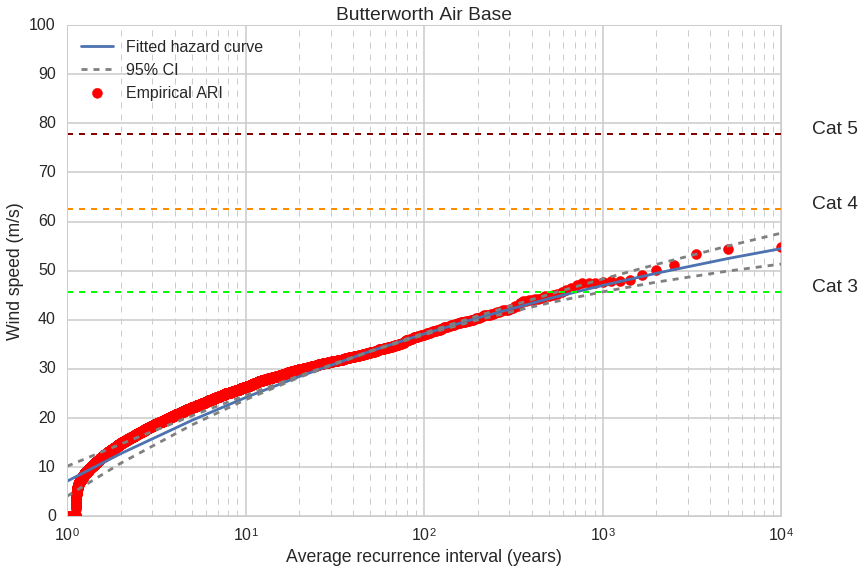

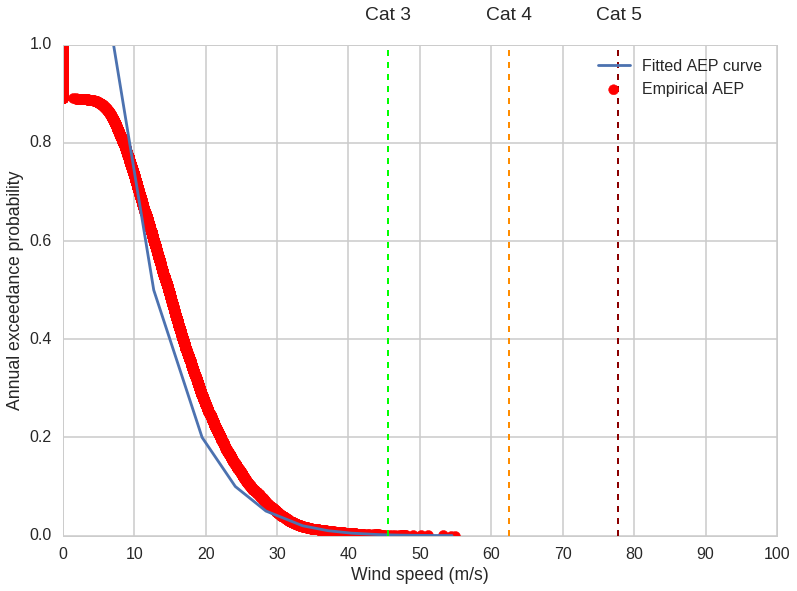

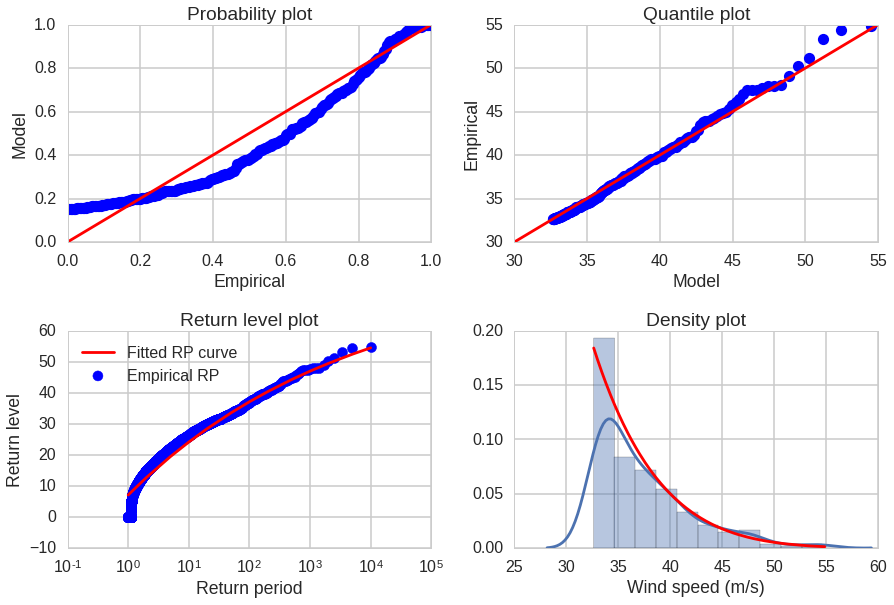

In [20]:
interact(fitGPD, locationName=widgets.Dropdown(options=locNameList))

In [ ]:
locName = "Port Hedland Bedout Island Aws"
locId = locations['locId'][locNameList.index(locName)]
rp = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
recs = database.locationRecords(db, locId)
data = np.zeros(int(10000 * 365.25))
data[-len(recs):] = recs['wspd']

xi, sigma, mu = selectThreshold(recs['wspd'])
thresh = np.percentile(np.array(recs['wspd']), 99.5)#recs['wspd'].max()/2
print(thresh)
gpd = genpareto.fit(data[data > thresh], floc=thresh)
print(gpd)
rate = float(len(data[data > mu])) / float(len(data))
rval = returnLevels(rp, mu, xi, sigma, rate)

rate2 = float(len(data[data > thresh])) / float(len(data))
rval2 = returnLevels(rp, thresh, gpd[0], gpd[2], rate2)

rprecs = database.locationAllReturnLevels(db, locId)

stdrlevs = 156. - 142.*np.power(rp, -0.1)
stdrlevs[np.where(rp >= 50)] *= 1.1

#stdrlevs = 122. - 104.*np.power(rp, -0.1)
#stdrlevs[np.where(rp >= 50)] *= 1.05

print("{0}, {1}, {2}".format(xi, sigma, mu))
print(gpd)
print(rval)
print(rval2)
emprp = empiricalReturnPeriod(data)
sortedmax = np.sort(data)
fig, ax1 = plt.subplots(1, 1)
ax1.semilogx(rp, rval, label="Fitted hazard curve (GPD)")
ax1.semilogx(rp, rval2 , label=r"$\mu$ = 99.5th %ile ({0:.3f})".format(thresh), color='0.5')
ax1.semilogx(rprecs['returnPeriod'], rprecs['wspd'], label="Fitted hazard curve (GEV)", color='g')
ax1.semilogx(rp, stdrlevs, label="AS1170.2", color='c')
ax1.scatter(emprp[emprp > 1], sortedmax[emprp > 1], s=100,
                color='r', label="Empirical ARI")

title_str = (locName   + "\n" +
             r"$\mu$ = {0:.3f}, $\xi$ = {1:.5f}, $\sigma$ = {2:.4f}".
             format(mu, xi, sigma))
ax1.set_title(title_str)
ax1.set_ylim((0, 100))
ax1.set_yticks(np.arange(0, 101, 10))
ax1.set_xlim((1, 10000))
ax1.set_ylabel('Wind speed (m/s)')
ax1.set_xlabel('Average recurrence interval (years)')
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle='--', linewidth=1)
ax1.axhline(45.6, c='lime', linestyle='--', linewidth=2)#, label='Cat 3')
ax1.axhline(62.5, c='darkorange', linestyle='--', linewidth=2)#, label='Cat 4')
ax1.axhline(77.8, c='darkred', linestyle='--', linewidth=2)#, label='Cat 5')
ax1.text(20000, 45.6, 'Cat 3', ha='center')
ax1.text(20000, 62.5, 'Cat 4', ha='center')
ax1.text(20000, 77.8, 'Cat 5', ha='center')
ax1.legend(loc=2)

In [ ]:
### DEPRECATED ###

def find_nearest_index(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

def calculateShape(mu, data):
    """
    :param float mu: threshold parameter for the GPD distribution.
    :param data: :class:`numpy.ndarray` of data values to fit.
    """
    nobs = len(data)
    nexc = len(data[data > mu])
    rate = float(nexc)/float(nobs)
    gpd = genpareto.fit(data[data > mu] - mu)

    return gpd

def selectThreshold(data):
    """
    Select an appropriate threshold for fitting a generalised pareto
    distribution. 
    
    The only constraint placed on the selection is that the shape 
    parameter is negative (such that the distribution is bounded).
    
    :param data: :class:`numpy.ndarray` containing the observed values (with 
                 missing values removed).
    :returns: tuple of the shape, scale and threshold.
    """
    
    sh = []
    sc = []
    t = []
    q1000list = []
    q10000list = []
    
    eps = -0.01
    datamax = data.max()
    nobs = len(data)
    startmu = data.compress(data > 0).max()/2.
    for mu in np.arange(startmu, datamax, 0.05):
        nexc = len(data[data > mu]) 
        rate = nexc / nobs
        if nexc < 10:
            break

        pp = calculateShape(mu, data)
        q1000, q10000 = returnLevels(np.array([1000, 10000]), mu, pp[0], pp[2], rate)
        if np.isnan(q1000):
            continue

        if np.isnan(q10000):
            continue

        qdiff = np.abs(q10000 - q1000)
        if pp[0] < eps and qdiff < 0.12*q10000 and qdiff > -eps: 
            t.append(mu)
            sh.append(pp[0])
            sc.append(pp[2])
            q1000list.append(q1000)
            q10000list.append(q10000)
            
    if len(t) == 0:
        print("No suitable shape parameters identified")
        return 0, 0, 0
    Av1000 = np.mean(np.array(q1000list))
    Av10000 = np.mean(np.array(q10000list))
    Av1000 = np.ceil(Av1000 + 0.05*Av1000)
    Av10000 = np.ceil(Av10000 + 0.05*Av10000)

    idx1000 = find_nearest_index(np.array(q1000list), Av1000)
    idx10000 = find_nearest_index(np.array(q10000list), Av10000)
    
    u1000 = t[idx1000]
    u10000 = t[idx10000]

    if u1000 > u10000:
        shmax = sh[idx1000]
        scmax = sc[idx1000]
    else:
        shmax = sh[idx10000]
        scmax = sc[idx10000]

    return shmax, scmax, u1000

In [ ]:
def plotRecords(locationName):
    locId = locations['locId'][locNameList.index(locationName)]
    recs = database.locationRecords(db, locId)
    ws = recs['wspd'].compress(recs['wspd']>0)
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(ws*3.6, linestyle='', marker='.', color='r')
    ax1.set_xlabel("Event number")
    ax1.set_ylabel("Wind gust (km/h)")
    ax1.set_ylim((0,360))
    ax1.set_yticks(np.arange(0, 361, 60))
    
    y = 1.0 - np.arange(len(ws))/len(ws)
    ax2.plot(ws*3.6, y, linestyle='', marker='.', color='r')
    ax2.set_xlabel("Wind gust (km/h)")
    ax2.set_ylabel("Probability")
    #ax2.axvline(69, c='k', linestyle='--', linewidth=1, label='Region C')
    ax2.axvline(45.6*3.6, c='k', linestyle='--', linewidth=1, label='Cat 3')

    ax2.axvline(62.5*3.6, c='k', linestyle='--', linewidth=1, label='Cat 4')
    ax2.axvline(77.8*3.6, c='k', linestyle='--', linewidth=1, label='Cat 5')
    ax2.text(45.6*3.6, 1.05, 'Cat 3', ha='center')
    ax2.text(62.5*3.6, 1.05, 'Cat 4', ha='center')
    ax2.text(77.8*3.6, 1.05, 'Cat 5', ha='center')
    ax2.set_xlim((0,360))
    ax2.set_xticks(np.arange(0, 361, 30))
    fig.tight_layout()

In [ ]:
interact(plotRecords, locationName=widgets.Dropdown(options=locNameList))

In [ ]:
def plotWindRose(locationName):
    locId = locations['locId'][locNameList.index(locationName)]
    recs = database.locationRecords(db, locId)
    speed = recs['wspd'].compress(recs['wspd']>0)
    direction = 2.*np.pi - (np.arctan2(-recs['vmax'], recs['umax']) - np.pi/2.)
    winddir = (180./np.pi) * np.mod(direction, 2. * np.pi)
    ax = WindroseAxes.from_ax()
    ax.box(winddir.compress(recs['wspd']>0), speed, normed=True, edgecolor='black', 
           bins=np.array([0, 17, 35, 45, 62, 77, 100,]), cmap=cm.hot)
    ax.set_legend()
    #print(recs['umax'])
    #print(recs['vmax'])
    #print(winddir.compress(recs['wspd']>0))
    #print(speed)

In [ ]:
interact(plotWindRose, locationName=widgets.Dropdown(options=locNameList))

In [ ]:
locationName='Rockhampton Airport'
locId = locations['locId'][locNameList.index(locationName)]
recs = database.locationRecords(db, locId)
speed = recs['wspd'].compress(recs['wspd']>0)
direction = 2. * np.pi - (np.arctan2(-recs['vmax'], recs['umax']) - np.pi/2.)
winddir = (180./np.pi) * np.mod(direction, 2. * np.pi)
ax = sns.distplot(speed, axlabel="Wind speed (m/s)", fit=lognorm, fit_kws={'color':'r', 'linestyle':'--'})
ax.set_xlim((0,100))

In [ ]:
fitGPD('Rockhampton Airport')

In [ ]:
df = pd.DataFrame({'wspd':recs['wspd'], 'umax':recs['umax'], 'vmax':recs['vmax']})
sns.pairplot(df)


In [ ]:
plotWindRose('Mackay Airport')

In [ ]:
locationName='Cairns Airport'
locId = locations['locId'][locNameList.index(locationName)]
recs = database.locationPassage(db, locId, 500)

In [ ]:
recsdf = pd.DataFrame(recs)
recsdf['year'] =  np.array([id.split('-')[1] for id in recsdf['eventId']])
recsdf.groupby('year').count()['eventId']

In [ ]:
locationName='Cairns Airport'
locId = locations['locId'][locNameList.index(locationName)]
recs = database.locationRecords(db, locId)
data = np.zeros(int(1000 * 365.25))
data[-len(recs):] = recs['wspd']

rp = np.array([1, 2, 5, 10, 20, 50, 100, 200,
                500, 1000, 2000, 5000, 10000])
rate = float(len(data[data > mu])) / float(len(data))
rval = returnLevels(rp, mu, xi, sigma, rate)

In [ ]:
for loc in locNameList:
    locId = locations['locId'][locNameList.index(loc)]
    recs = database.locationRecords(db, locId)
    xi, sigma, mu = selectThreshold(recs['wspd'])
    thresh = np.percentile(recs['wspd'], 95)
    gpd = genpareto.fit(recs['wspd'][recs['wspd'] > thresh], floc=thresh)
    
    print("{0}: {1:.5f}, {2:.5f}, {3:.5f}, {4:.5f} | {5}".format(loc, xi, sigma, mu, recs['wspd'].max()/2, gpd))
    rate = float(len(data[data > mu])) / float(len(data))
    rval = returnLevels(rp, mu, xi, sigma, rate)

    rate2 = float(len(data[data > thresh])) / float(len(data))
    rval2 = returnLevels(rp, thresh, gpd[0], gpd[2], rate2)

    #print("{0}, {1}, {2}".format(xi, sigma, mu))
    #print(gpd)
    #print(rval)
    #print(rval2)
    emprp = empiricalReturnPeriod(data)
    sortedmax = np.sort(data)
    fig, ax1 = plt.subplots(1, 1)
    ax1.semilogx(rp, rval, label="Fitted hazard curve")
    ax1.semilogx(rp, rval2 , label=r"$\mu$ = {0}".format(max(data)/2), color='0.5')
    ax1.scatter(emprp[emprp > 1], sortedmax[emprp > 1], s=100,
                    color='r', label="Empirical ARI")

    title_str = (locName   + "\n" +
                 r"$\mu$ = {0:.3f}, $\xi$ = {1:.5f}, $\sigma$ = {2:.4f}".
                 format(mu, xi, sigma))
    ax1.set_title(title_str)
    ax1.set_ylim((0, 100))
    ax1.set_yticks(np.arange(0, 101, 10))
    ax1.set_xlim((1, 10000))
    ax1.set_ylabel('Wind speed (m/s)')
    ax1.set_xlabel('Average recurrence interval (years)')
    ax1.grid(which='major', linestyle='-')
    ax1.grid(which='minor', linestyle='--', linewidth=1)
    ax1.axhline(45.6, c='lime', linestyle='--', linewidth=2)#, label='Cat 3')
    ax1.axhline(62.5, c='darkorange', linestyle='--', linewidth=2)#, label='Cat 4')
    ax1.axhline(77.8, c='darkred', linestyle='--', linewidth=2)#, label='Cat 5')
    ax1.text(20000, 45.6, 'Cat 3', ha='center')
    ax1.text(20000, 62.5, 'Cat 4', ha='center')
    ax1.text(20000, 77.8, 'Cat 5', ha='center')
    ax1.legend(loc=2)
    plt.savefig()

50.8845998383
(-0.11882267998181117, 50.884599838256818, 8.3939644411306595)
-0.0815905759898, 8.18422638773, 76.9578460693
(-0.11882267998181117, 50.884599838256818, 8.3939644411306595)
[  4.7569646   14.24235891  25.98570333  34.30383947  42.16460447
  51.8965848   58.79001604  65.30441327  73.3695298   79.08227524
  84.48090645  91.1646545   95.89893838]
[ 29.08597973  36.39450019  45.17667942  51.21305117  56.77218062
  63.45222913  68.04371548  72.27219379  77.35328436  80.84573775
  84.06207386  87.92693821  90.5834267 ]


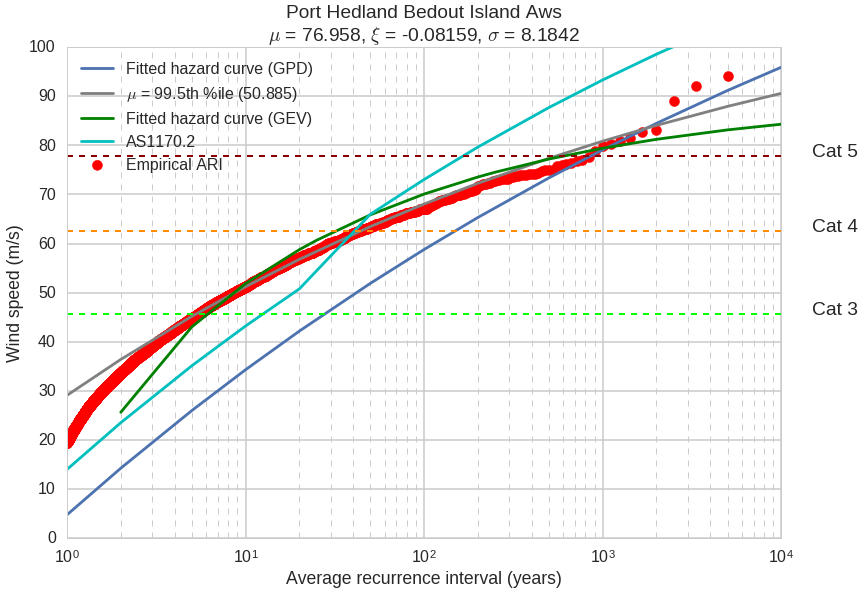

In [23]:
locName = "Port Hedland Bedout Island Aws"
locId = locations['locId'][locNameList.index(locName)]
rp = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
recs = database.locationRecords(db, locId)
data = np.zeros(int(10000 * 365.25))
data[-len(recs):] = recs['wspd']

xi, sigma, mu = selectThreshold(recs['wspd'])
thresh = np.percentile(np.array(recs['wspd']), 99.5)#recs['wspd'].max()/2
print(thresh)
gpd = genpareto.fit(data[data > thresh], floc=thresh)
print(gpd)
rate = float(len(data[data > mu])) / float(len(data))
rval = returnLevels(rp, mu, xi, sigma, rate)

rate2 = float(len(data[data > thresh])) / float(len(data))
rval2 = returnLevels(rp, thresh, gpd[0], gpd[2], rate2)

rprecs = database.locationAllReturnLevels(db, locId)

stdrlevs = 156. - 142.*np.power(rp, -0.1)
stdrlevs[np.where(rp >= 50)] *= 1.1

#stdrlevs = 122. - 104.*np.power(rp, -0.1)
#stdrlevs[np.where(rp >= 50)] *= 1.05

print("{0}, {1}, {2}".format(xi, sigma, mu))
print(gpd)
print(rval)
print(rval2)
emprp = empiricalReturnPeriod(data)
sortedmax = np.sort(data)
fig, ax1 = plt.subplots(1, 1)
ax1.semilogx(rp, rval, label="Fitted hazard curve (GPD)")
ax1.semilogx(rp, rval2 , label=r"$\mu$ = 99.5th %ile ({0:.3f})".format(thresh), color='0.5')
ax1.semilogx(rprecs['returnPeriod'], rprecs['wspd'], label="Fitted hazard curve (GEV)", color='g')
ax1.semilogx(rp, stdrlevs, label="AS1170.2", color='c')
ax1.scatter(emprp[emprp > 1], sortedmax[emprp > 1], s=100,
                color='r', label="Empirical ARI")

title_str = (locName   + "\n" +
             r"$\mu$ = {0:.3f}, $\xi$ = {1:.5f}, $\sigma$ = {2:.4f}".
             format(mu, xi, sigma))
ax1.set_title(title_str)
ax1.set_ylim((0, 100))
ax1.set_yticks(np.arange(0, 101, 10))
ax1.set_xlim((1, 10000))
ax1.set_ylabel('Wind speed (m/s)')
ax1.set_xlabel('Average recurrence interval (years)')
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle='--', linewidth=1)
ax1.axhline(45.6, c='lime', linestyle='--', linewidth=2)#, label='Cat 3')
ax1.axhline(62.5, c='darkorange', linestyle='--', linewidth=2)#, label='Cat 4')
ax1.axhline(77.8, c='darkred', linestyle='--', linewidth=2)#, label='Cat 5')
ax1.text(20000, 45.6, 'Cat 3', ha='center')
ax1.text(20000, 62.5, 'Cat 4', ha='center')
ax1.text(20000, 77.8, 'Cat 5', ha='center')
ax1.legend(loc=2)